## Modelling Draft <br>
Framework: Tensorflow Keras <br>
Base models to test: <br>
<li>Xception </li>
<li>MobileNet </li>
<li>NasNet Mobile ✓ </li>

#### Import Packages

In [2]:
# from PIL import Image
# from tensorflow.keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import random
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from time import perf_counter

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('All modules are loaded')

All modules are loaded


In [4]:
#Labels
# t_stg= ['is','1','1a','1b','1c','2','2a','2b','3','4']
n_stg = ['0','1','2','3']
# m_stg = ['0','1','1a','1b','1c','2','3'] 

#Load the image batches, labels == t,m,n
n_raw_df = pd.read_csv(r'D:\Lung-PET-CT-Dx\manifest\raw_ct_delimited.csv',usecols=['filenames','n'])
raw_dir = r'C:\Users\lzsnc\Desktop\Raw CT resized'
n_raw_df.head()

,filenames,n
0,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-13.tiff,3
1,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-14.tiff,3
2,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-15.tiff,3
3,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-16.tiff,3
4,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-17.tiff,3


#### Split Dataset: <br>
80% Train, 20% Test

In [6]:
n_train_df, n_test_df = train_test_split(n_raw_df, test_size=0.2, random_state=42)
n_train_df.tail()

,filenames,n
29802,Lung_Dx-G0060_01-21-2011-NA-PET01PTheadlung Adult-07418_10.000000-Thorax 1.0 B70f-17914_1-168.tiff,1
5390,Lung_Dx-A0170_12-02-2010-NA-PET03CBMWholebodyFirstHead Adult-02190_10.000000-Thorax 1.0 B70f-48719_1-150.tiff,2
860,Lung_Dx-A0030_10-08-2008-NA-LUNGCTA-12839_2.000000-5mm Stnd SS50-99357_3-034.tiff,3
15795,Lung_Dx-A0242_06-30-2010-NA-PET03WholebodyFirstHead Adult-08887_10.000000-Thorax 1.0 B70f-74050_1-077.tiff,0
23654,Lung_Dx-G0017_10-24-2009-NA-LUNGC-80644_2.000000-A phase 5mm Stnd SS50-33209_2-033.tiff,0


In [7]:
#convert 'n' stage value to string
n_train_df['n'] = n_train_df['n'].apply(str)
n_test_df['n'] = n_test_df['n'].apply(str)
n_test_df.head()

,filenames,n
13351,Lung_Dx-A0225_02-24-2010-NA-PET03WholebodyFirstHead Adult-94548_17.000000-Range-CT WB 1.0 B30f-Tra-ALPHA Range-84398_1-097.tiff,0
6885,Lung_Dx-A0179_02-18-2011-NA-PETNEW02CBMWholebodyOnly Adult-71135_6.000000-Range-CT WB 1.0 B30f-Tra-ALPHA Range-45198_1-138.tiff,0
1588,Lung_Dx-A0065_10-26-2008-NA-lungc-32319_3.000000-5mm Lung SS50-68818_1-34.tiff,1
1109,Lung_Dx-A0041_05-20-2009-NA-ThoraxAThoraxRoutine Adult-95129_3.000000-ThoraxRoutine 10.0 B40f-76978_1-08.tiff,1
8980,Lung_Dx-A0193_09-16-2009-NA-PET03WholebodyFirstHead Adult-73161_15.000000-CT WB 1.0 B30f-21761_1-135.tiff,1


#### Train/Test for 'T' Stage

In [8]:
train_batch = 32
train_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,)

n_train_ds = train_datagen.flow_from_dataframe(
    dataframe=n_train_df,
    directory=raw_dir,
    x_col='filenames',
    y_col='n',
    class_mode='categorical',
    shuffle=True,
    seed=32
)

Found 24250 validated image filenames belonging to 4 classes.


In [9]:
np.unique(n_train_ds.classes)

array([0, 1, 2, 3])

#### Test Image Generator

In [10]:
test_batch = 32
test_datagen = ImageDataGenerator(rescale=1 / 255.0)
n_test_ds = test_datagen.flow_from_dataframe(
    dataframe=n_test_df,
    directory=raw_dir,
    x_col='filenames',
    y_col='n',
    class_mode='categorical',
    shuffle=False, 
    seed=32 
)

Found 6063 validated image filenames belonging to 4 classes.


In [11]:
#Validate number of n-stage classes
n_class_dict = n_train_ds.class_indices
print(n_class_dict)
n_num_classes = len(n_class_dict)
n_num_classes

{'0': 0, '1': 1, '2': 2, '3': 3}


4

In [12]:
n_class_dict

{'0': 0, '1': 1, '2': 2, '3': 3}

Add Weights to Solve Data Imbalance

In [13]:
n_class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
           classes=np.unique(n_train_ds.classes),
           y=n_train_ds.classes)
n_class_weights = dict(zip(np.unique(n_train_ds.classes), n_class_weights))
n_class_weights

{0: 0.47807743868780067,
 1: 0.887628111273792,
 2: 6.020357497517378,
 3: 1.6244640943193998}

Model 3: NasNet

In [14]:
base_model = NASNetMobile(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['stem_bn1[0][0]']       

In [15]:
#Add random seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value) #use in dropout

In [16]:
#Create the model
model = Sequential()
model.add(base_model)
# model.add(Dropout(0.3))
model.add(tensorflow.keras.layers.GlobalAveragePooling2D())
model.add(BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001))
model.add(tensorflow.keras.layers.Reshape((-1,1)))
model.add(tensorflow.keras.layers.AveragePooling1D())
model.add(Flatten())
model.add(Dropout(0.3,seed=seed_value))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3,seed=seed_value))
model.add(Dense(n_num_classes,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d (  (None, 1056)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1056)              4224      
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 1056, 1)           0         
                                                                 
 average_pooling1d (Average  (None, 528, 1)            0         
 Pooling1D)                                                      
                                                        

In [17]:
learning_rate = 0.0001
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Actual Training

In [18]:
os.chdir(r'D:\Lung-PET-CT-Dx\manifest\Models')
checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint("multiclass_n_stage_nasnet_mobile_v2.h5",
                     save_best_only=True, # only keep the best model weights on file (delete the rest)
                     save_weights_only=False,   # save only the model weights
                     verbose=1, # don't print out whether or not model is being saved
                     monitor='val_loss')

early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              mode='auto',
                                              patience=5)

In [19]:
start = perf_counter()
history = model.fit(n_train_ds,
                    epochs=20,
                    steps_per_epoch=len(n_train_ds),
                    validation_data=n_test_ds,
                    validation_steps=len(n_test_ds),
                    callbacks=[checkpoint_callback, early_stop],
                    verbose=1,
                    class_weight=n_class_weights)
end = perf_counter()
print(end - start)

Epoch 1/20
758/758 [==============================] - ETA: 0s - loss: 1.4689 - accuracy: 0.3658
Epoch 1: val_loss improved from inf to 1.21324, saving model to multiclass_n_stage_nasnet_mobile_v2.h5
758/758 [==============================] - 857s 1s/step - loss: 1.4689 - accuracy: 0.3658 - val_loss: 1.2132 - val_accuracy: 0.4640
Epoch 2/20
758/758 [==============================] - ETA: 0s - loss: 1.2572 - accuracy: 0.4065
Epoch 2: val_loss improved from 1.21324 to 1.14616, saving model to multiclass_n_stage_nasnet_mobile_v2.h5
758/758 [==============================] - 856s 1s/step - loss: 1.2572 - accuracy: 0.4065 - val_loss: 1.1462 - val_accuracy: 0.4976
Epoch 3/20
758/758 [==============================] - ETA: 0s - loss: 1.1510 - accuracy: 0.4275
Epoch 3: val_loss improved from 1.14616 to 1.06253, saving model to multiclass_n_stage_nasnet_mobile_v2.h5
758/758 [==============================] - 854s 1s/step - loss: 1.1510 - accuracy: 0.4275 - val_loss: 1.0625 - val_accuracy: 0.5443

Load model - skip training <br>
Approximate training time: 16788.0334156 seconds


In [20]:
#Evaluate performance
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

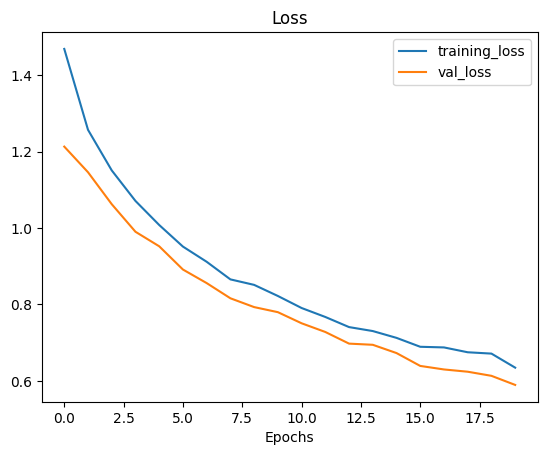

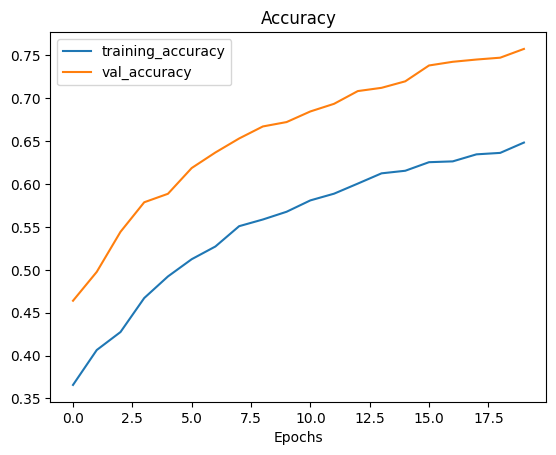

In [21]:
plot_loss_curves(history)

190/190 [==============================] - 168s 865ms/step
Confusion Matrix
Classification Report for N-Stage
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      3158
           1       0.68      0.75      0.72      1708
           2       0.68      0.99      0.81       272
           3       0.60      0.93      0.73       925

    accuracy                           0.76      6063
   macro avg       0.72      0.84      0.76      6063
weighted avg       0.80      0.76      0.76      6063



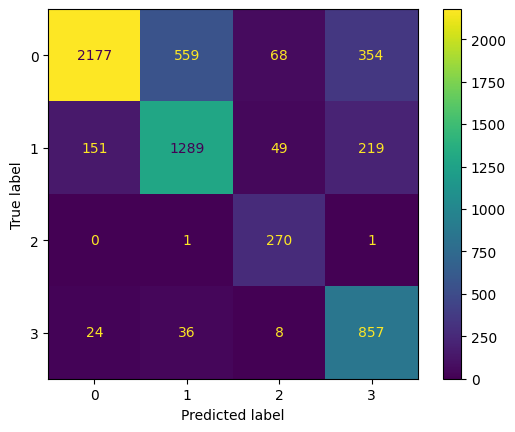

In [22]:
# n_Y_pred = vgg16_mod.predict(n_test_ds) #predictions
n_Y_pred = model.predict(n_test_ds) #predictions
n_Y_ground = n_test_df.n.to_list()
n_y_pred = np.argmax(n_Y_pred,axis=1)
print('Confusion Matrix')
cm = confusion_matrix(n_test_ds.classes, n_y_pred)
# cm = confusion_matrix(t_Y_ground, t_Y_pred,normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=n_stg)
cmd.plot()

print('Classification Report for N-Stage')

print(classification_report(n_test_ds.classes, n_y_pred, target_names=n_stg))


In [23]:
from tensorflow.keras.preprocessing import image
test_img = r'C:\Users\lzsnc\Desktop\Raw CT Images\Lung_Dx-A0030_10-08-2008-NA-LUNGCTA-12839_2.000000-5mm Stnd SS50-99357_1-037.tiff'
test = image.load_img(test_img, target_size=(224,224))
test_img_array = image.img_to_array(test)
img_batch = np.expand_dims(test_img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
print(prediction[0])

1/1 [==============================] - 3s 3s/step
[0.14267765 0.15662992 0.00137655 0.6993159 ]
